# Latent Diffusion Model Inference for Dark Sky Spectra

This notebook demonstrates how to:
1. Load and enrich DESI Sky Spectra VAC with solar flux and coordinate data
2. Load pre-trained VAE and LDM models
3. Generate conditional samples using the LatentDiffusionSampler

All functionality has been refactored into production-ready modules in `desisky`.

## Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1 only

import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("JAX is using device:", jax.devices())

JAX is using device: [CudaDevice(id=0)]


## Load and Enrich Data

We'll load the DESI Sky Spectra VAC and add:
- Solar flux measurements (for space weather)
- Galactic coordinates (for ISL modeling)
- Ecliptic coordinates (for zodiacal light modeling)

In [2]:
from desisky.data import (
    SkySpecVAC,
    attach_solar_flux,
    add_galactic_coordinates,
    add_ecliptic_coordinates
)

# Load the VAC
vac = SkySpecVAC(version="v1.0", download=True, verify=True)
print(f"Data file location: {vac.filepath()}")

# Load wavelength, flux, and metadata
wavelength, flux, metadata = vac.load()

print(f"Wavelength shape: {wavelength.shape}")  # (7781,)
print(f"Flux shape: {flux.shape}")              # (9176, 7781)
print(f"Metadata shape: {metadata.shape}")      # (9176, 22)
print(f"\nAvailable metadata columns:\n{list(metadata.columns)}")

Data file location: /home/mdowicz/.desisky/data/dr1/sky_spectra_vac_v1.fits
Wavelength shape: (7781,)
Flux shape: (9176, 7781)
Metadata shape: (9176, 22)

Available metadata columns:
['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'EXPTIME', 'AIRMASS', 'EBV', 'SEEING_ETC', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'MOONFRAC', 'MOONALT', 'MOONSEP', 'SUNALT', 'SUNSEP', 'OBSALT', 'OBSAZ']


### Add Solar Flux Data

In [3]:
# Load solar flux measurements
solar_df = pd.read_csv('/home/mdowicz/Sky_Spec/data/Solar_data/solarflux-2004-2025.csv')
solar_df['datetime'] = pd.to_datetime(solar_df['datetime'])

# Attach to metadata using nearest-time matching
metadata = attach_solar_flux(metadata, solar_df, time_tolerance="12h")

Matched solar-flux values for 9170 / 9176 exposures (tolerance = 12h).


### Add Coordinate Transformations

In [4]:
# Add Galactic coordinates (for ISL modeling)
metadata = add_galactic_coordinates(metadata)

# Add Ecliptic coordinates (for zodiacal light modeling)
metadata = add_ecliptic_coordinates(metadata)

print(f"\nEnriched metadata columns:\n{list(metadata.columns)}")


Enriched metadata columns:
['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'EXPTIME', 'AIRMASS', 'EBV', 'SEEING_ETC', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'MOONFRAC', 'MOONALT', 'MOONSEP', 'SUNALT', 'SUNSEP', 'OBSALT', 'OBSAZ', 'SOLFLUX', 'GALLON', 'GALLAT', 'ECLLON', 'ECLLAT']


### Filter to Dark Sky Subset

For this LDM, we'll use observations with:
- Sun altitude < -20° (astronomical twilight)
- Moon altitude < -5° (Moon well below horizon)
- Valid transparency measurements

In [5]:
# Create dark time mask
mask = (
    (metadata["SUNALT"] < -20) &
    (metadata["MOONALT"] < -5) &
    (metadata["TRANSPARENCY_GFA"] > 0)
)

# Apply filter
metadata = metadata.loc[mask].reset_index(drop=True)
flux = flux[mask]

print(f"Dark time subset: {len(metadata)} exposures")

Dark time subset: 3364 exposures


### Prepare Conditioning Features

The LDM expects these 8 conditioning features:
1. OBSALT - Observation altitude
2. TRANSPARENCY_GFA - Atmospheric transparency
3. SUNALT - Sun altitude
4. SOLFLUX - Solar flux (10.7 cm)
5. ECLLON - Ecliptic longitude
6. ECLLAT - Ecliptic latitude
7. GALLON - Galactic longitude
8. GALLAT - Galactic latitude

In [6]:
CONDITIONING_COLS = [
    "OBSALT", "TRANSPARENCY_GFA", "SUNALT", "SOLFLUX",
    "ECLLON", "ECLLAT", "GALLON", "GALLAT"
]

conditioning = metadata[CONDITIONING_COLS].to_numpy(dtype=np.float32)
print(f"Conditioning shape: {conditioning.shape}")

Conditioning shape: (3364, 8)


## Load Pre-trained Models

Load the VAE (for encoding/decoding) and LDM (for diffusion sampling).

In [7]:
from desisky.io import load_builtin

# Load VAE
vae, vae_meta = load_builtin("vae")

print("VAE Architecture:")
print(f"  Input channels: {vae_meta['arch']['in_channels']}")
print(f"  Latent dimension: {vae_meta['arch']['latent_dim']}")
print(f"  Model schema version: {vae_meta['schema']}")

# Test VAE forward pass
result = vae(flux[:10], jax.random.PRNGKey(21))
print(f"\nVAE output keys: {result.keys()}")
print(f"  Latent shape: {result['latent'].shape}")

VAE Architecture:
  Input channels: 7781
  Latent dimension: 8
  Model schema version: 0

VAE output keys: dict_keys(['mean', 'logvar', 'latent', 'output'])
  Latent shape: (10, 8)


In [8]:
# Load LDM (Latent Diffusion Model)
ldm, ldm_meta = load_builtin("ldm_dark")

print("LDM Architecture:")
print(f"  Model architecture: {ldm_meta['arch']}")
print(f"  Model schema version: {ldm_meta['schema']}")

LDM Architecture:
  Model architecture: {'in_ch': 1, 'out_ch': 1, 'meta_dim': 8, 'hidden': 32, 'levels': 3, 'emb_dim': 32}
  Model schema version: 0


## Generate Samples with LatentDiffusionSampler

The `LatentDiffusionSampler` provides a clean API for generating samples.

### Example 1: Generate samples with custom conditions

In [9]:
from desisky.inference import LatentDiffusionSampler

# Create sampler with Heun method (recommended)
sampler = LatentDiffusionSampler(
    ldm_model=ldm,
    vae_model=vae,
    method="heun",       # Options: "heun", "ddim", "ddpm"
    num_steps=1000,      # More steps = higher quality
    n_T=1000,
    latent_channels=1,
    latent_dim=8
)

print(sampler)

LatentDiffusionSampler(
  method=heun,
  num_steps=1000,
  n_T=1000,
  latent_shape=(1, 8)
)


In [10]:
# Define custom conditions (OBSALT, TRANSP, SUNALT, SOLFLUX, ECLLON, ECLLAT, GALLON, GALLAT)
custom_conditions = jnp.array([
    [60.0, 0.9, -30.0, 150.0, 45.0, 10.0, 120.0, 5.0],   # Dark sky, high transparency
    [70.0, 0.85, -25.0, 155.0, 50.0, 12.0, 125.0, 6.0],  # Different position
])

# Generate spectra
generated_spectra = sampler.sample(
    key=jr.PRNGKey(42),
    conditioning=custom_conditions,
    guidance_scale=2.0  # Higher = stronger conditioning
)

print(f"Generated {len(generated_spectra)} spectra")
print(f"Shape: {generated_spectra.shape}")

Generated 2 spectra
Shape: (2, 7781)


### Example 2: Generate from real metadata

In [11]:
# Use real observations as conditioning
n_samples = 100
real_conditions = conditioning[:n_samples]

generated_spectra_2, generated_latents = sampler.sample(
    key=jr.PRNGKey(123),
    conditioning=real_conditions,
    guidance_scale=2.5,
    return_latents=True  # Also return latent representations
)

print(f"Generated spectra shape: {generated_spectra_2.shape}")
print(f"Generated latents shape: {generated_latents.shape}")

Generated spectra shape: (100, 7781)
Generated latents shape: (100, 1, 8)


### Example 3: Compare sampling methods

In [12]:
test_cond = conditioning[0:1]  # Single sample

print("Comparing sampling methods:")
print("-" * 60)

for method in ["heun", "ddim"]:
    method_sampler = LatentDiffusionSampler(
        ldm, vae, method=method, num_steps=40
    )
    spec = method_sampler.sample(
        key=jr.PRNGKey(0),  # Same seed for comparison
        conditioning=test_cond,
        guidance_scale=1.0
    )
    print(f"{method.upper():5s}: mean flux = {spec.mean():.3f}, std = {spec.std():.3f}")

Comparing sampling methods:
------------------------------------------------------------
HEUN : mean flux = 1.091, std = 1.336
DDIM : mean flux = 261.232, std = 836.891


## Visualize Results

Compare generated vs. real spectra

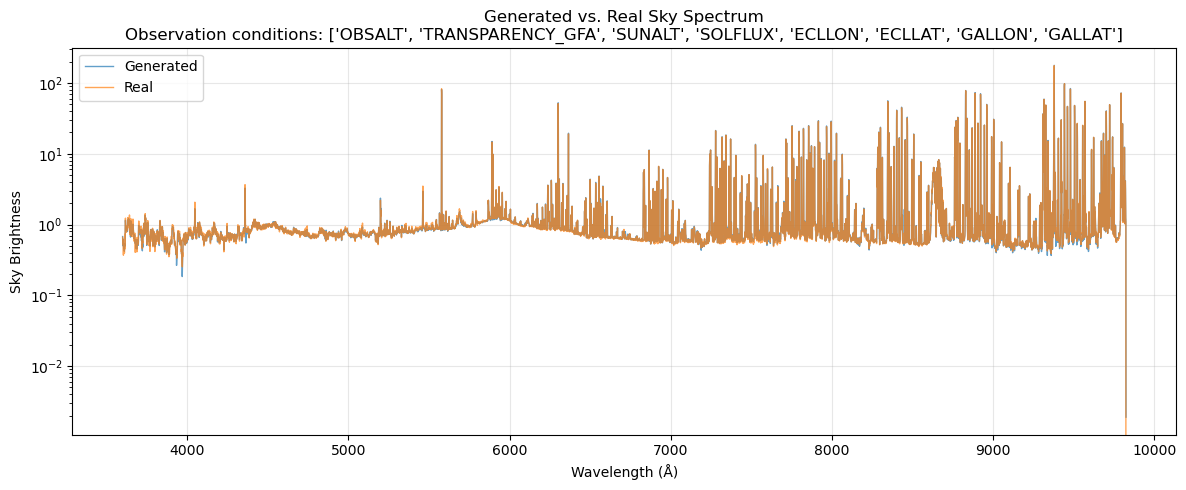


Conditioning values:
  OBSALT              : 40.30
  TRANSPARENCY_GFA    : 1.12
  SUNALT              : -24.50
  SOLFLUX             : 72.10
  ECLLON              : 179.58
  ECLLAT              : -0.05
  GALLON              : 275.50
  GALLAT              : 60.14


In [13]:
# Generate a spectrum matching a real observation
test_idx = 1
test_cond = conditioning[test_idx]

sampler = LatentDiffusionSampler(
    ldm_model=ldm,
    vae_model=vae,
    method="heun",
    num_steps=1000,
    n_T=1000,
    latent_channels=1,
    latent_dim=8
)

spec = sampler.sample(
    key=jr.PRNGKey(0),
    conditioning=test_cond,
    guidance_scale=1.0
)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(wavelength, spec.squeeze(), alpha=0.7, label='Generated', linewidth=1)
plt.plot(wavelength, flux[test_idx], alpha=0.7, label='Real', linewidth=1)
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('Sky Brightness')
plt.yscale('log')
plt.title(f'Generated vs. Real Sky Spectrum\nObservation conditions: {CONDITIONING_COLS}')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print conditioning values
print("\nConditioning values:")
for col, val in zip(CONDITIONING_COLS, test_cond):
    print(f"  {col:20s}: {val:.2f}")

## Summary

This notebook demonstrated:

1. **Data Enrichment**: Using `desisky.data` functions to add solar flux and coordinate transformations
2. **Model Loading**: Loading pre-trained VAE and LDM models with `desisky.io.load_builtin()`
3. **Sampling**: Using `LatentDiffusionSampler` for clean, production-ready inference

All functionality is now available in the `desisky` package with:
- Comprehensive docstrings
- Type hints
- Unit tests
- Production-ready code organization